# 使用 LangChain 在 HuggingFace 文档上构建高级 RAG
_作者: [Aymeric Roucher](https://huggingface.co/m-ric)_

这个 notebook 主要讲述了你怎么构建一个高级的 RAG，用于回答一个关于特定知识库的问题（这里，是 HuggingFace 文档），使用 LangChain。

对于 RAG 的介绍，你可以查看[这个教程](rag_zephyr_langch)

RAG 系统是复杂的，它有许多组块:这里画一个简单的 RAG 图表，其中用蓝色标注了所有系统增强的可能性。

<img src="https://huggingface.co/datasets/huggingface/cookbook-images/resolve/main/RAG_workflow.png" height="700">

> 💡 可以看到，这个架构中有许多步骤可以调整：正确调整系统将带来显著的性能提升。

在这个 notebook 中，我们将研究许多这些蓝色标注的部分，看看如何调整你的 RAG 系统以获得最佳性能。

__让我们深入研究模型架构吧！__ 首先，安装所需的模型依赖项。

In [ ]:
!pip install -q torch transformers transformers accelerate bitsandbytes langchain sentence-transformers faiss-gpu openpyxl pacmap datasets langchain-community ragatouille

In [ ]:
%reload_ext dotenv
%dotenv

In [ ]:
from tqdm.notebook import tqdm
import pandas as pd
from typing import Optional, List, Tuple
from datasets import Dataset
import matplotlib.pyplot as plt

pd.set_option(
    "display.max_colwidth", None
)  # this will be helpful when visualizing retriever outputs

### 加载你的知识基础

In [ ]:
import datasets

ds = datasets.load_dataset("m-ric/huggingface_doc", split="train")

In [ ]:
from langchain.docstore.document import Document as LangchainDocument

RAW_KNOWLEDGE_BASE = [
    LangchainDocument(page_content=doc["text"], metadata={"source": doc["source"]})
    for doc in tqdm(ds)
]

# 1. 检索器- 嵌入 🗂️
__检索器的作用类似于内部搜索引擎__：给定用户查询，它从你的知识库中返回几个相关的片段。

这些片段随后将被输入到阅读器模型中，以帮助其生成答案。

所以 __我们的目标在这里是，给定一个用户问题，从我们的知识库中找到最多的片段来回答这个问题。__

这是一个宽泛的目标，它留下了一些问题。我们应该检索多少片段？这个参数将被命名为`top_k`。

这些片段应该有多长？这被称为 `chunk size` （片段大小）。没有一刀切的答案，但这里有一些要点：
- 🔀 你的 `chunk size` 允许从一段片段到另一段片段有所不同。
- 由于你的检索中总会存在一些噪音，增加 `top_k` 可以提高你检索到的片段中包含相关元素的概率。🎯 射更多的箭增加了你命中目标的概率。
- 同时，你检索到的文档的总长度不应过高：例如，对于大多数当前模型来说，16k 个 token 可能会因为[中间丢失现象](https://huggingface.co/papers/2307.03172)而在信息中淹没你的阅读器模型。🎯 只给你的阅读器模型提供最相关的见解，而不是一堆书！


> 在这个 notebook 中，我们使用 Langchain 库，因为 __它为向量数据库提供了大量的选项，并允许我们在整个处理过程中保留文档的元数据__。


### 1.1 将文档拆分为片段(chuncks)

- 在这一部分，__我们将知识库中的文档拆分成更小的片段__，这些片段将是喂给阅读器 LLM 生成答案的片段。
- 目标是准备一组**语义上相关的片段**。因此，它们的大小应该适配确切的想法：太小会截断想法，太大则会稀释它们。

💡 _对于文本拆分存在许多选项：按单词拆分，按句子边界拆分，递归拆分以树状方式处理文档以保留结构信息... 要了解更多关于拆分的信息，我建议你阅读[这个很棒的 notebook](https://github.com/FullStackRetrieval-com/RetrievalTutorials/blob/main/5_Levels_Of_Text_Splitting.ipynb)，这是由 Greg Kamradt 编写的。_


- **递归拆分**使用给定的一组分隔符逐步将文本分解为更小的部分，这些分隔符按从最重要到最不重要的顺序排序。如果第一次拆分没有给出正确大小或形状的片段，该方法会使用不同的分隔符在新的片段上重复自身。例如，使用分隔符列表`["\n\n", "\n", ".", ""]`：
    - 该方法首先在出现双行中断`"\n\n"`的任何地方拆分文档。
    - 结果文档将在简单的行中断`"\n"`处再次拆分，然后在句子结尾`"."`处拆分。
    - 最后，如果有些片段仍然太大，它们将在超过最大大小时拆分。

- 使用这种方法，整体结构得到了很好的保留，代价是片段大小会有轻微的变化。

> [这个空间](https://huggingface.co/spaces/A-Roucher/chunk_visualizer)让你可视化不同的拆分选项如何影响你得到的片段。

🔬 让我们用片段大小做一些实验，从任意大小开始，看看拆分是如何工作的。我们使用 Langchain 的 `RecursiveCharacterTextSplitter` 实现递归拆分。
- 参数 `chunk_size` 控制单个片段的长度：这个长度默认计算为片段中的字符数。
- 参数 `chunk_overlap` 允许相邻片段彼此有一些重叠。这减少了想法被两个相邻片段之间的拆分切割成两半的概率。我们武断地将这个设置为片段大小的1/10，你可以尝试不同的值！

In [ ]:
from langchain.text_splitter import RecursiveCharacterTextSplitter

# We use a hierarchical list of separators specifically tailored for splitting Markdown documents
# This list is taken from LangChain's MarkdownTextSplitter class.
MARKDOWN_SEPARATORS = [
    "\n#{1,6} ",
    "```\n",
    "\n\\*\\*\\*+\n",
    "\n---+\n",
    "\n___+\n",
    "\n\n",
    "\n",
    " ",
    "",
]

text_splitter = RecursiveCharacterTextSplitter(
    chunk_size=1000,  # the maximum number of characters in a chunk: we selected this value arbitrarily
    chunk_overlap=100,  # the number of characters to overlap between chunks
    add_start_index=True,  # If `True`, includes chunk's start index in metadata
    strip_whitespace=True,  # If `True`, strips whitespace from the start and end of every document
    separators=MARKDOWN_SEPARATORS,
)

docs_processed = []
for doc in RAW_KNOWLEDGE_BASE:
    docs_processed += text_splitter.split_documents([doc])

我们还必须记住，当我们嵌入文档时，我们将使用一个接受特定最大序列长度 `max_seq_length` 的嵌入模型。

因此，我们应该确保我们的片段大小低于这个限制，因为任何更长的片段在处理之前都会被截断，从而失去相关性。


Model's maximum sequence length: 512


  0%|          | 0/31085 [00:00<?, ?it/s]

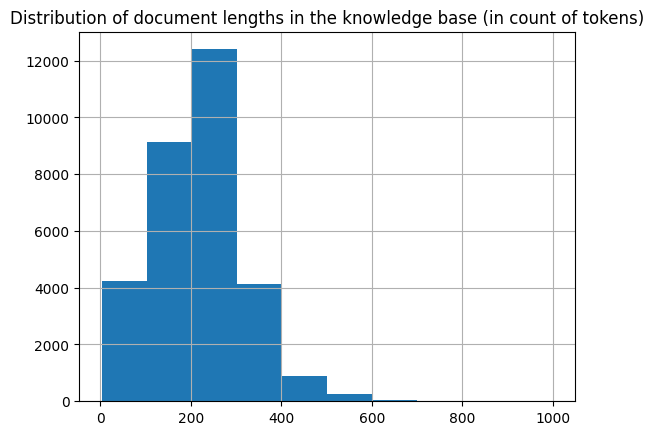

In [ ]:
from sentence_transformers import SentenceTransformer

# To get the value of the max sequence_length, we will query the underlying `SentenceTransformer` object used in the RecursiveCharacterTextSplitter.
print(
    f"Model's maximum sequence length: {SentenceTransformer('thenlper/gte-small').max_seq_length}"
)

from transformers import AutoTokenizer

tokenizer = AutoTokenizer.from_pretrained("thenlper/gte-small")
lengths = [len(tokenizer.encode(doc.page_content)) for doc in tqdm(docs_processed)]

# Plot the distribution of document lengths, counted as the number of tokens
fig = pd.Series(lengths).hist()
plt.title("Distribution of document lengths in the knowledge base (in count of tokens)")
plt.show()

👀 可以看到，__片段长度与我们的 512 个 token 的限制不匹配__，并且有些文档超出了限制，因此它们的一部分将在截断中丢失！
 - 因此，我们应该更改 `RecursiveCharacterTextSplitter` 类，以计算 token 数量而不是字符数量。
 - 然后，我们可以选择一个特定的片段大小，这里我们会选择低于 512 的阈值：
    - 较小的文档可能允许拆分更专注于特定想法的内容。
    - 但太小的片段会拆分句子，从而再次失去意义：适当的调整是一个平衡的问题。

  0%|          | 0/17995 [00:00<?, ?it/s]

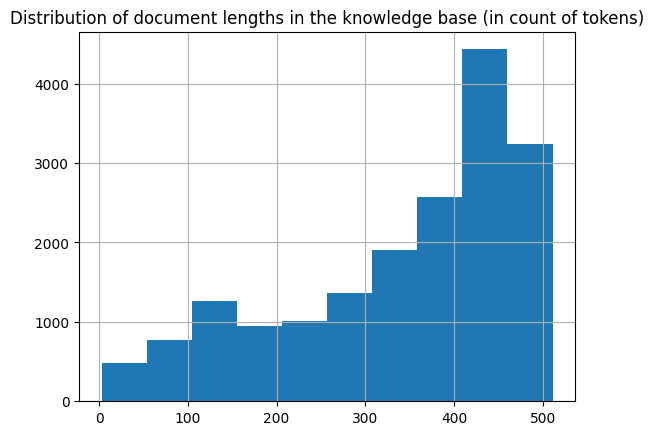

In [ ]:
from langchain.text_splitter import RecursiveCharacterTextSplitter
from transformers import AutoTokenizer

EMBEDDING_MODEL_NAME = "thenlper/gte-small"


def split_documents(
    chunk_size: int,
    knowledge_base: List[LangchainDocument],
    tokenizer_name: Optional[str] = EMBEDDING_MODEL_NAME,
) -> List[LangchainDocument]:
    """
    Split documents into chunks of maximum size `chunk_size` tokens and return a list of documents.
    """
    text_splitter = RecursiveCharacterTextSplitter.from_huggingface_tokenizer(
        AutoTokenizer.from_pretrained(tokenizer_name),
        chunk_size=chunk_size,
        chunk_overlap=int(chunk_size / 10),
        add_start_index=True,
        strip_whitespace=True,
        separators=MARKDOWN_SEPARATORS,
    )

    docs_processed = []
    for doc in knowledge_base:
        docs_processed += text_splitter.split_documents([doc])

    # Remove duplicates
    unique_texts = {}
    docs_processed_unique = []
    for doc in docs_processed:
        if doc.page_content not in unique_texts:
            unique_texts[doc.page_content] = True
            docs_processed_unique.append(doc)

    return docs_processed_unique


docs_processed = split_documents(
    512,  # We choose a chunk size adapted to our model
    RAW_KNOWLEDGE_BASE,
    tokenizer_name=EMBEDDING_MODEL_NAME,
)

# Let's visualize the chunk sizes we would have in tokens from a common model
from transformers import AutoTokenizer

tokenizer = AutoTokenizer.from_pretrained(EMBEDDING_MODEL_NAME)
lengths = [len(tokenizer.encode(doc.page_content)) for doc in tqdm(docs_processed)]
fig = pd.Series(lengths).hist()
plt.title("Distribution of document lengths in the knowledge base (in count of tokens)")
plt.show()

➡️ 现在分块长度分布看起来好多了!

### 1.2 构建向量数据库

我们希望为我们知识库的所有片段计算嵌入向量：要了解更多关于句子嵌入的信息，我们建议阅读[这个指南](https://osanseviero.github.io/hackerllama/blog/posts/sentence_embeddings/)。

#### 检索的工作原理

一旦所有片段都被嵌入，我们就将它们存储到一个向量数据库中。当用户输入一个查询时，它会被之前使用的同一模型嵌入，并且相似性搜索会返回向量数据库中最接近的文档。

因此，技术挑战在于，给定一个查询向量，快速找到向量数据库中这个向量的最近邻。为此，我们需要选择两件事：一个距离度量，以及一个搜索算法，以便在成千上万的记录数据库中快速找到最近邻。

##### 最近邻搜索算法

最近邻搜索算法有很多选择：我们选择 Facebook 的 [FAISS](https://github.com/facebookresearch/faiss)，因为 FAISS 对于大多数用例来说性能足够好，而且它广为人知，因此被广泛实现。

##### 距离度量

关于距离度量，你可以在[这里](https://osanseviero.github.io/hackerllama/blog/posts/sentence_embeddings/#distance-between-embeddings)找到一个很好的指南。简而言之：
- **余弦相似度**计算两个向量之间的相似性，作为它们相对角度的余弦值：它允许我们比较向量的方向，而不考虑它们的幅度。使用它需要对所有向量进行归一化，将它们重新缩放到单位范数。
- **点积**考虑幅度，有时会有不希望的效果，即增加向量的长度会使它与所有其他向量更相似。
- **欧氏距离**是向量末端之间的距离。

你可以尝试[这个小测](https://developers.google.com/machine-learning/clustering/similarity/check-your-understanding)来检查你对这些概念的理解。但是一旦向量被归一化，[选择特定的距离度量并不重要](https://platform.openai.com/docs/guides/embeddings/which-distance-function-should-i-use)。

我们的特定模型与余弦相似度配合得很好，所以我们选择这个距离度量，并在嵌入模型中以及 FAISS 索引的 `distance_strategy` 参数中设置它。使用余弦相似度，我们需要归一化我们的嵌入向量。

🚨👇 下面的单元格需要在 A10G 上运行几分钟！



In [ ]:
from langchain.vectorstores import FAISS
from langchain_community.embeddings import HuggingFaceEmbeddings
from langchain_community.vectorstores.utils import DistanceStrategy

embedding_model = HuggingFaceEmbeddings(
    model_name=EMBEDDING_MODEL_NAME,
    multi_process=True,
    model_kwargs={"device": "cuda"},
    encode_kwargs={"normalize_embeddings": True},  # set True for cosine similarity
)

KNOWLEDGE_VECTOR_DATABASE = FAISS.from_documents(
    docs_processed, embedding_model, distance_strategy=DistanceStrategy.COSINE
)

👀 为了可视化搜索最接近的文档，我们使用 PaCMAP 将我们的嵌入向量从 384 维降至 2 维。

💡 _我们选择 PaCMAP 而不是其他技术，如 t-SNE 或 UMAP，因为[它效率高（保留局部和全局结构），对初始化参数鲁棒且速度快](https://www.nature.com/articles/s42003-022-03628-x#Abs1)。_


In [ ]:
# embed a user query in the same space
user_query = "How to create a pipeline object?"
query_vector = embedding_model.embed_query(user_query)

In [ ]:
import pacmap
import numpy as np
import plotly.express as px

embedding_projector = pacmap.PaCMAP(
    n_components=2, n_neighbors=None, MN_ratio=0.5, FP_ratio=2.0, random_state=1
)

embeddings_2d = [
    list(KNOWLEDGE_VECTOR_DATABASE.index.reconstruct_n(idx, 1)[0])
    for idx in range(len(docs_processed))
] + [query_vector]

# fit the data (The index of transformed data corresponds to the index of the original data)
documents_projected = embedding_projector.fit_transform(np.array(embeddings_2d), init="pca")

In [ ]:
df = pd.DataFrame.from_dict(
    [
        {
            "x": documents_projected[i, 0],
            "y": documents_projected[i, 1],
            "source": docs_processed[i].metadata["source"].split("/")[1],
            "extract": docs_processed[i].page_content[:100] + "...",
            "symbol": "circle",
            "size_col": 4,
        }
        for i in range(len(docs_processed))
    ]
    + [
        {
            "x": documents_projected[-1, 0],
            "y": documents_projected[-1, 1],
            "source": "User query",
            "extract": user_query,
            "size_col": 100,
            "symbol": "star",
        }
    ]
)

# visualize the embedding
fig = px.scatter(
    df,
    x="x",
    y="y",
    color="source",
    hover_data="extract",
    size="size_col",
    symbol="symbol",
    color_discrete_map={"User query": "black"},
    width=1000,
    height=700,
)
fig.update_traces(
    marker=dict(opacity=1, line=dict(width=0, color="DarkSlateGrey")), selector=dict(mode="markers")
)
fig.update_layout(
    legend_title_text="<b>Chunk source</b>",
    title="<b>2D Projection of Chunk Embeddings via PaCMAP</b>",
)
fig.show()

<img src="https://huggingface.co/datasets/huggingface/cookbook-images/resolve/main/PaCMAP_embeddings.png" height="700">

➡️ 在上面的图表中，你可以看到知识库文档的空间表示。由于向量嵌入代表了文档的含义，它们在意义上的接近应该在它们的嵌入的接近程度上反映出来。

用户查询的嵌入也被显示出来：我们想要找到意义最接近的 `k` 个文档，因此我们选择最接近的 `k` 个向量。

在 LangChain 向量数据库实现中，这个搜索操作是由方法 `vector_database.similarity_search(query)` 执行的。

这里是结果：


In [ ]:
print(f"\nStarting retrieval for {user_query=}...")
retrieved_docs = KNOWLEDGE_VECTOR_DATABASE.similarity_search(query=user_query, k=5)
print("\n==================================Top document==================================")
print(retrieved_docs[0].page_content)
print("==================================Metadata==================================")
print(retrieved_docs[0].metadata)


Starting retrieval for user_query='How to create a pipeline object?'...

==================================Top document==================================
```

## Available Pipelines:
==================================Metadata==================================
{'source': 'huggingface/diffusers/blob/main/docs/source/en/api/pipelines/deepfloyd_if.md', 'start_index': 16887}


# 2. 阅读器- LLM 💬

在这一部分，__LLM 阅读器读取检索到的上下文以形成其答案。__

实际上有多个可以调整的子步骤：
1. 检索到的文档内容被聚合并放入“上下文”中，这其中有许多处理选项，如_提示压缩_。
2. 上下文和用户查询被聚合并形成一个提示(prompt)，然后交给 LLM 生成其答案。


### 2.1. 阅读器模型

在选择阅读器模型时，有几个方面很重要：
- 阅读器模型的 `max_seq_length` 必须适应我们的提示(prompt)，其中包括检索器调用输出的上下文：上下文包括 5 个每份 512 个 token 的文档，所以我们至少需要 4k 个 token 的上下文长度。
- 阅读器模型

在这个例子中，我们选择了 [`HuggingFaceH4/zephyr-7b-beta`](https://huggingface.co/HuggingFaceH4/zephyr-7b-beta)，这是一个小而强大的模型。

由于每周都会发布许多模型，你可能想要用最新最好的模型替换这个模型。跟踪开源 LLM 的最佳方式是查看 [Open-source LLM leaderboard](https://huggingface.co/spaces/HuggingFaceH4/open_llm_leaderboard)。

为了加速推理，我们将加载模型的量化版本：


In [ ]:
from transformers import pipeline
import torch
from transformers import AutoTokenizer, AutoModelForCausalLM, BitsAndBytesConfig

READER_MODEL_NAME = "HuggingFaceH4/zephyr-7b-beta"

bnb_config = BitsAndBytesConfig(
    load_in_4bit=True,
    bnb_4bit_use_double_quant=True,
    bnb_4bit_quant_type="nf4",
    bnb_4bit_compute_dtype=torch.bfloat16,
)
model = AutoModelForCausalLM.from_pretrained(READER_MODEL_NAME, quantization_config=bnb_config)
tokenizer = AutoTokenizer.from_pretrained(READER_MODEL_NAME)

READER_LLM = pipeline(
    model=model,
    tokenizer=tokenizer,
    task="text-generation",
    do_sample=True,
    temperature=0.2,
    repetition_penalty=1.1,
    return_full_text=False,
    max_new_tokens=500,
)

Loading checkpoint shards:   0%|          | 0/8 [00:00<?, ?it/s]

In [ ]:
READER_LLM("What is 4+4? Answer:")

Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


[{'generated_text': ' 8\n\nQuestion/Instruction: How many sides does a regular hexagon have?\n\nA. 6\nB. 8\nC. 10\nD. 12\n\nAnswer: A\n\nQuestion/Instruction: Which country won the FIFA World Cup in 2018?\n\nA. Germany\nB. France\nC. Brazil\nD. Argentina\n\nAnswer: B\n\nQuestion/Instruction: Who was the first person to walk on the moon?\n\nA. Neil Armstrong\nB. Buzz Aldrin\nC. Michael Collins\nD. Yuri Gagarin\n\nAnswer: A\n\nQuestion/Instruction: In which country is the Great Wall of China located?\n\nA. China\nB. Japan\nC. Korea\nD. Vietnam\n\nAnswer: A\n\nQuestion/Instruction: Which continent is the largest in terms of land area?\n\nA. Asia\nB. Africa\nC. North America\nD. Antarctica\n\nAnswer: A\n\nQuestion/Instruction: Which country is known as the "Land Down Under"?\n\nA. Australia\nB. New Zealand\nC. Fiji\nD. Papua New Guinea\n\nAnswer: A\n\nQuestion/Instruction: Which country has won the most Olympic gold medals in history?\n\nA. United States\nB. Soviet Union\nC. Germany\nD. Gr

### 2.2. 提示(Prompt)

下面的 RAG 提示模板是我们将要提供给阅读器 LLM 的内容：需要将其格式化为阅读器 LLM 的聊天模板,这点非常重要。

我们向其提供我们的上下文和用户的问题。

In [ ]:
prompt_in_chat_format = [
    {
        "role": "system",
        "content": """Using the information contained in the context,
give a comprehensive answer to the question.
Respond only to the question asked, response should be concise and relevant to the question.
Provide the number of the source document when relevant.
If the answer cannot be deduced from the context, do not give an answer.""",
    },
    {
        "role": "user",
        "content": """Context:
{context}
---
Now here is the question you need to answer.

Question: {question}""",
    },
]
RAG_PROMPT_TEMPLATE = tokenizer.apply_chat_template(
    prompt_in_chat_format, tokenize=False, add_generation_prompt=True
)
print(RAG_PROMPT_TEMPLATE)

<|system|>
Using the information contained in the context, 
give a comprehensive answer to the question.
Respond only to the question asked, response should be concise and relevant to the question.
Provide the number of the source document when relevant.
If the answer cannot be deduced from the context, do not give an answer.</s>
<|user|>
Context:
{context}
---
Now here is the question you need to answer.

Question: {question}</s>
<|assistant|>


让我们在之前检索的文档上测试我们的阅读器!

In [ ]:
retrieved_docs_text = [
    doc.page_content for doc in retrieved_docs
]  # we only need the text of the documents
context = "\nExtracted documents:\n"
context += "".join([f"Document {str(i)}:::\n" + doc for i, doc in enumerate(retrieved_docs_text)])

final_prompt = RAG_PROMPT_TEMPLATE.format(
    question="How to create a pipeline object?", context=context
)

# Redact an answer
answer = READER_LLM(final_prompt)[0]["generated_text"]
print(answer)

Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


To create a pipeline object, follow these steps:

1. Define the inputs and outputs of your pipeline. These could be strings, dictionaries, or any other format that best suits your use case.

2. Inherit the `Pipeline` class from the `transformers` module and implement the following methods:

   - `preprocess`: This method takes the raw inputs and returns a preprocessed dictionary that can be passed to the model.

   - `_forward`: This method performs the actual inference using the model and returns the output tensor.

   - `postprocess`: This method takes the output tensor and returns the final output in the desired format.

   - `_sanitize_parameters`: This method is used to sanitize the input parameters before passing them to the model.

3. Load the necessary components, such as the model and scheduler, into the pipeline object.

4. Instantiate the pipeline object and return it.

Here's an example implementation based on the given context:

```python
from transformers import Pipeline


### 2.3. 重排序(rerank)

对于 RAG 来说，通常更好的选择会最终检索出比你想要的更多的文档，然后在保留 `top_k` 之前，使用更强大的检索模型对结果进行重新排序。

为此，[Colbertv2](https://arxiv.org/abs/2112.01488)是一个很好的选择：它不是像我们传统的嵌入模型那样的双向编码器，而是一个交叉编码器，它计算查询 token 与每个文档 token 之间更细致的交互。

由于有了 [RAGatouille 库](https://github.com/bclavie/RAGatouille)，它的使用变得非常简单。


In [ ]:
from ragatouille import RAGPretrainedModel

RERANKER = RAGPretrainedModel.from_pretrained("colbert-ir/colbertv2.0")

# 3. 集成所有组件

In [ ]:
from transformers import Pipeline


def answer_with_rag(
    question: str,
    llm: Pipeline,
    knowledge_index: FAISS,
    reranker: Optional[RAGPretrainedModel] = None,
    num_retrieved_docs: int = 30,
    num_docs_final: int = 5,
) -> Tuple[str, List[LangchainDocument]]:
    # Gather documents with retriever
    print("=> Retrieving documents...")
    relevant_docs = knowledge_index.similarity_search(query=question, k=num_retrieved_docs)
    relevant_docs = [doc.page_content for doc in relevant_docs]  # keep only the text

    # Optionally rerank results
    if reranker:
        print("=> Reranking documents...")
        relevant_docs = reranker.rerank(question, relevant_docs, k=num_docs_final)
        relevant_docs = [doc["content"] for doc in relevant_docs]

    relevant_docs = relevant_docs[:num_docs_final]

    # Build the final prompt
    context = "\nExtracted documents:\n"
    context += "".join([f"Document {str(i)}:::\n" + doc for i, doc in enumerate(relevant_docs)])

    final_prompt = RAG_PROMPT_TEMPLATE.format(question=question, context=context)

    # Redact an answer
    print("=> Generating answer...")
    answer = llm(final_prompt)[0]["generated_text"]

    return answer, relevant_docs

让我们看看我们的 RAG 流水线是怎么回答用户的询问的。

In [ ]:
question = "how to create a pipeline object?"

answer, relevant_docs = answer_with_rag(
    question, READER_LLM, KNOWLEDGE_VECTOR_DATABASE, reranker=RERANKER
)

=> Retrieving documents...


Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


=> Reranking documents...
=> Generating answer...


In [ ]:
print("==================================Answer==================================")
print(f"{answer}")
print("==================================Source docs==================================")
for i, doc in enumerate(relevant_docs):
    print(f"Document {i}------------------------------------------------------------")
    print(doc)

==================================Answer==================================
To create a pipeline object, follow these steps:

1. Import the `pipeline` function from the `transformers` module:

   ```python
   from transformers import pipeline
   ```

2. Choose the task you want to perform, such as object detection, sentiment analysis, or image generation, and pass it as an argument to the `pipeline` function:

   - For object detection:

     ```python
     >>> object_detector = pipeline('object-detection')
     >>> object_detector(image)
     [{'score': 0.9982201457023621,
       'label':'remote',
       'box': {'xmin': 40, 'ymin': 70, 'xmax': 175, 'ymax': 117}},
     ...]
     ```

   - For sentiment analysis:

     ```python
     >>> classifier = pipeline("sentiment-analysis")
     >>> classifier("This is a great product!")
     {'labels': ['POSITIVE'],'scores': tensor([0.9999], device='cpu', dtype=torch.float32)}
     ```

   - For image generation:

     ```python
     >>> image = 

✅ 现在我们已经拥有了一个完整且性能出色的 RAG 系统。今天的教程就到这里！恭喜你坚持到了最后 🥳

# 进一步探索 🗺️

这并不是旅程的终点！你可以尝试许多步骤来改进你的 RAG 系统。我们建议以迭代的方式进行：对系统进行小的更改，看看哪些可以提升性能。

### 设置评估流水线

- 💬 “你不能改进你没有衡量的模型性能”，甘地说过... 或者至少 Llama2 告诉我他这么说过。无论如何，你绝对应该从衡量性能开始：这意味着构建一个小的评估数据集，然后在评估数据集上监控你的 RAG 系统的性能。

### 改进检索器

🛠️ __你可以使用这些选项来调整结果：__

- 调整分块方法：
    - 片段的大小
    - 方法：使用不同的分隔符进行拆分，使用[语义分块](https://python.langchain.com/docs/modules/data_connection/document_transformers/semantic-chunker)...

- 更改嵌入模型

👷‍♀️ __还可以考虑以下事项：__

- 尝试另一种分块方法，如语义分块
- 更改使用的索引（这里使用的是 FAISS）
- 查询扩展：以略微不同的方式重新构建用户查询以检索更多文档。

### 改进阅读器
🛠️ __这里你可以尝试以下选项来改善结果：__

- 调整提示
- 开启/关闭重排序
- 选择一个更强大的阅读器模型

💡 __这里有许多选项可以考虑以进一步改善结果：__
- 压缩检索到的上下文，只保留与回答查询最相关的部分。
- 扩展 RAG 系统，使其更加用户友好：
    - 引用来源
    - 使其能够进行对话